# Setup

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.spatial import cKDTree
import seaborn as sns
import pandas as pd
import os
import random
import re
import cv2
import gc
import logging

SkLearn libraries:

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE

TensorFlow libraries:

In [3]:
import tensorflow as tf
from tensorflow import keras as tfk
import keras
!pip install -q keras_cv
import keras_cv as kcv
from keras_cv.layers import RandomApply
print(f"TensorFlow version {tf.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 23.3 MB/s eta 0:00:00
TensorFlow version 2.17.1


Some settings:

In [4]:
SEED = 42

# Set seed for random
random.seed(SEED)

# Set seed for numpy
np.random.seed(SEED) # NumPy

# Set seed for TensorFlow
tf.random.set_seed(SEED)
# TensorFlow automatically handles GPU seed as well, no need for manual seed setting

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

tf.autograph.set_verbosity(0)
tf.compat.v1.set_random_seed(SEED)

Some viz settings:

In [5]:
plt.tight_layout();
pd.set_option('display.max_rows', None);
# pd.reset_option('display.max_rows')

<Figure size 640x480 with 0 Axes>

# Data Handling

## Resource Downloads

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Data Import

In [7]:
SHARED_DIR = "/content/gdrive/MyDrive/AN2DL_hw_1"
MY_DIR = "/content/gdrive/MyDrive/blood_dir"

Import the public set:

In [8]:
with np.load(SHARED_DIR+"/training_set.npz", allow_pickle=True) as data:
    images = data['images']
    labels = data['labels'].reshape(-1)
num_classes = len(np.unique(labels))
images.shape, labels.shape, num_classes

((13759, 96, 96, 3), (13759,), 8)

## Data Exploration

In [9]:
def show_images(images, labels, n_images=5, n_cols=5, predict=False):
  sns.set_style("whitegrid")  # Set Seaborn style

  n_rows = int(np.ceil(n_images / n_cols))

  # Define a base size for each subplot
  base_size = 5
  fig_size = (n_cols * base_size, n_rows * base_size)

  fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=fig_size)
  axs = axs.flatten()

  random_idxs = np.random.choice(len(images), n_images, replace=False) # for random images
  # random_idxs = range(len(images)) # for ordered images

  images_to_show = images[random_idxs]
  labels_to_show = labels[random_idxs]

  if predict == True:
    preds_to_show = MODEL.predict(images_to_show)

  for i, ax in enumerate(axs[:n_images]):
    idx = range(len(labels))[random_idxs[i]]

    img_to_show = images_to_show[i]
    label = labels_to_show[i]

    img_title = f"Image {idx + 1} - Class {label}"

    if predict == True:
      pred = preds_to_show[i]
      suff = f" - Pred {pred}"
      img_title += suff

    ax.set_title(img_title, fontsize=21)
    ax.imshow(img_to_show)
    ax.axis('off')  # Hide axes ticks

  # Hide any remaining empty subplots
  for ax in axs[n_images:]:
    ax.axis('off')

  plt.tight_layout()
  plt.show()

## Data Cleaning

Remove duplicates:

In [10]:
images, unique_idxs = np.unique(images, axis=0, return_index=True)
labels = labels[unique_idxs]
images.shape, labels.shape

((11953, 96, 96, 3), (11953,))

Remove anomalies:

In [ ]:
class_counts = np.bincount(labels)

shrek = images[58]
rick = images[1008]

In [12]:
shrek_idxs = np.all(images == shrek, axis=(1, 2, 3))
rick_idxs = np.all(images == rick, axis=(1, 2, 3))
print(f"{shrek_idxs.sum()} shreks")
print(f"{rick_idxs.sum()} rick")
# TODO for now let's keep Rick

1 shreks
1 rick


In [13]:
idxs_to_delete = shrek_idxs + rick_idxs
images = np.delete(images, idxs_to_delete, axis=0)
labels = np.delete(labels, idxs_to_delete, axis=0)
images.shape, labels.shape

((11951, 96, 96, 3), (11951,))

## Data Splitting

Split between train+val and test sets:

In [14]:
val_split = 0.15

X_train, X_val, y_train, y_val = train_test_split(
    images, labels,
    test_size = val_split,
    random_state = SEED,
    shuffle = True,
    stratify = labels
)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

del images, labels
gc.collect();

(10158, 96, 96, 3) (10158,)
(1793, 96, 96, 3) (1793,)


## Tensors

In [15]:
X_train = tf.convert_to_tensor(X_train/255.0, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.uint8)
X_val   = tf.convert_to_tensor(X_val/255.0, dtype=tf.float32)
y_val   = tf.convert_to_tensor(y_val, dtype=tf.uint8)
gc.collect();
X_train.device, X_train.dtype

('/job:localhost/replica:0/task:0/device:GPU:0', tf.float32)

# Model Init

## Model Loading

In [16]:
def load_model(file_path, compile=True):
    MODEL = tfk.models.load_model(file_path, compile=compile)
    return MODEL

In [17]:
# file_path = f"params.keras"               # for model saved on local runtime
file_path = f"{MY_DIR}/params_0.97_tom.keras"    # for model saved on google drive
# file_path = f"{MY_DIR}/params_cnxl2_balanced.keras"    # for model saved on google drive
MODEL = load_model(file_path, compile=False)

## Model Viz

In [18]:
def _get_all_layers(layer, data):
    if isinstance(layer, tfk.Model):  # Check if the layer is a model (nested layers)
        for sub_layer in layer.layers:
            _get_all_layers(sub_layer, data)  # Recursively call for nested layers
    else:
        data.append({"Layer Name": layer.name, "Trainable": layer.trainable})

def get_model_df(model, nested=False):
    data = []
    for layer in model.layers:
        if nested:
            _get_all_layers(layer, data)  # Get all layers, including nested ones
        else:
            data.append({"Layer Name": layer.name, "Trainable": layer.trainable})
    return pd.DataFrame(data)

In [32]:
# get_model_df(MODEL)

# Model Fitting

## Model Compilation

In [ ]:
get_model_df(MODEL, nested=False)

Compile the model:

In [20]:
def compile_model(MODEL, lr=1e-4):
    # compile the model with loss, optimizer, and metrics
    loss = tfk.losses.SparseCategoricalCrossentropy()
    optimizer = tfk.optimizers.Lion(
        learning_rate=lr,
        weight_decay=1e-4,
        gradient_accumulation_steps=2,
    )

    metrics = ['accuracy']
    MODEL.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [21]:
compile_model(MODEL, lr=1e-6)

## Datasets

In [22]:
BATCH_SIZE=64
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Resize images:

In [23]:
def preprocess_image(image, label):
  """Resizes and preprocesses the image."""
  image = tf.image.resize(image, [224, 224])
  # Add any other preprocessing steps if needed
  return image, label

In [24]:
train_ds = train_ds.map(preprocess_image)
val_ds = val_ds.map(preprocess_image)

## Training

In [25]:
MODEL.evaluate(train_ds);
MODEL.evaluate(val_ds);

159/159 ━━━━━━━━━━━━━━━━━━━━ 419s 2s/step - accuracy: 0.9989 - loss: 0.0035
29/29 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.9964 - loss: 0.0084


# Evaluation

In [26]:
def compute_metrics(labels, preds):
  accuracy = round(accuracy_score(labels, preds), 4)
  precision = round(precision_score(labels, preds, average='weighted'), 4)
  recall = round(recall_score(labels, preds, average='weighted'), 4)
  f1 = round(f1_score(labels, preds, average='weighted'), 4)

  result_dict = {
      "acc":  accuracy,
      "prec": precision,
      "rec":  recall,
      "f1":  f1,
  }

  return result_dict

In [27]:
preds_train     = np.argmax(MODEL.predict(train_ds, verbose=0), axis=-1)
labels_train    = y_train
preds_val       = np.argmax(MODEL.predict(val_ds, verbose=0), axis=-1)
labels_val      = y_val

In [28]:
print(f"TRAIN METRICS: \n {compute_metrics(labels_train, preds_train)}")
print(f"VAL METRICS: \n {compute_metrics(labels_val, preds_val)}")

TRAIN METRICS: 
 {'acc': 0.9988, 'prec': 0.9988, 'rec': 0.9988, 'f1': 0.9988}
VAL METRICS: 
 {'acc': 0.9972, 'prec': 0.9972, 'rec': 0.9972, 'f1': 0.9972}


In [29]:
cmn_train = confusion_matrix(labels_train, preds_train, normalize="true")
cmn_val = confusion_matrix(labels_val, preds_val, normalize="true")

cm_train = confusion_matrix(labels_train, preds_train)
cm_val = confusion_matrix(labels_val, preds_val)

In [30]:
def make_cm_fig(cm, cmn, title=None):
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
  fig.suptitle(title, fontsize=16)
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5, square=True, ax=axs[0])
  axs[0].set_title("Conf. matrix")
  axs[0].set_xlabel("Predicted label")
  axs[0].set_ylabel("True label")

  sns.heatmap(cmn, annot=True, fmt=".2%", cmap="Blues", linewidths=.5, square=True, ax=axs[1])
  axs[1].set_title("Norm. conf. matrix")
  axs[1].set_xlabel("Predicted label")
  axs[1].set_ylabel("True label")

  return fig

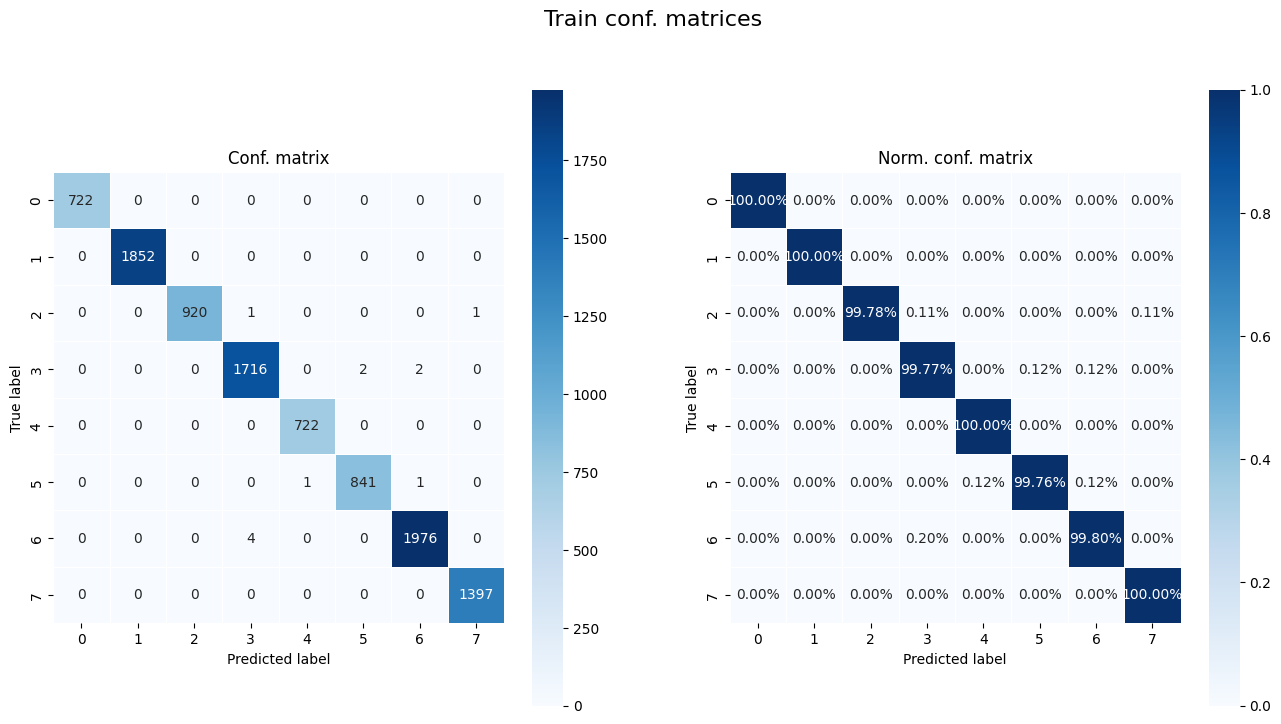

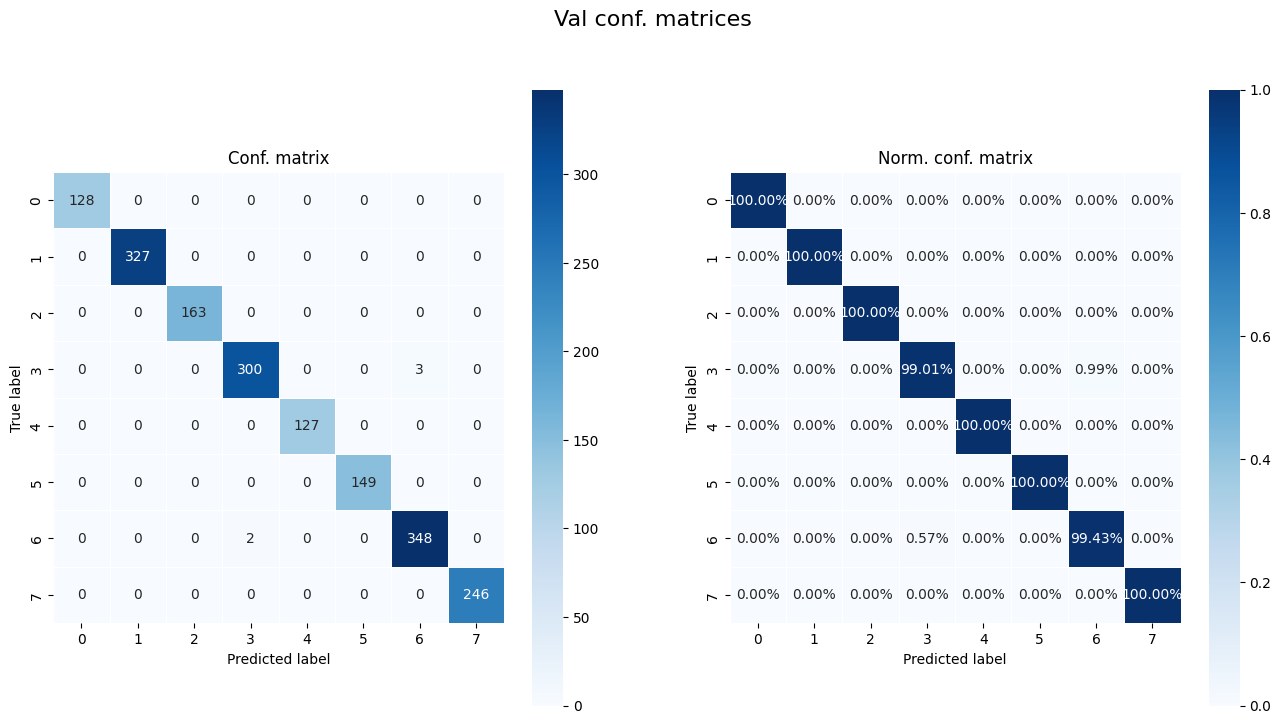

In [31]:
make_cm_fig(cm_train, cmn_train, title="Train conf. matrices").show()
make_cm_fig(cm_val, cmn_val, title="Val conf. matrices").show()